<a href="https://colab.research.google.com/github/RichardKameri/Machine-learning-2/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentiment Analysis**


This is a notebook containing Sentiment Analysis Mini Project on Amazon Musical Instruments Reviews. I am interested in Natural Language Processing and that is my motivation to make this project. I think that sentiment analysis has a really powerful impacts in business developments because we can gain so many insights from here.

**Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as p

NLP Text **Libraries**

In [2]:

import string
import re
import nltk
import nltk.corpus
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


EDA **Analysis**

In [3]:
# Text Polarity
from textblob import TextBlob

# Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word Cloud
from wordcloud import WordCloud

Feature **Engineering**

In [4]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Resampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Splitting Dataset
from sklearn.model_selection import train_test_split

Model Selection and **Evaluation**

In [5]:
# Model Building
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

**The Dataset**

The dataset that we will use is taken from Kaggle website and can be downloaded here:

Amazon Musical Instruments Reviews

There are two formats available of the dataset: JSON and CSV. We will use the CSV one in this project.

Overall, the dataset talks about the feedback received after the customers purchased musical instruments from Amazon.



In [6]:
# read the dataset
dataset = pd.read_csv("/content/Musical_instruments_reviews.csv")

In [7]:
# shape of the dataset
dataset.shape

(10261, 9)

Data **Preprocessing**

Checking Null **Values**

In [8]:
# Checking Null Values
dataset.isnull().sum()

,0
reviewerID,0
asin,0
reviewerName,27
helpful,0
reviewText,7
overall,0
summary,0
unixReviewTime,0
reviewTime,0


From above, there are two columns in the dataset with null values: reviewText and reviewerName. While the latter one is not really important, we should focus on the first column. We cannot remove these rows because the ratings and summary given from the customers will have some effects to our model later (although the number of missing rows is small). Because of it, we can fill the empty values with an empty string

Filling Missing **Values**

In [9]:
# Filling Missing Values
dataset["reviewText"].fillna("", inplace=True)

<ipython-input-9-6b91e804a191>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset["reviewText"].fillna("", inplace=True)


Concatenate reviewText and summary **Columns**

In [10]:
dataset["reviews"] = dataset["reviewText"] + " " + dataset["summary"]
dataset.drop(columns = ["reviewText", "summary"], axis = 1, inplace = True)

Statistic Description of The **Dataset**

In [11]:
# Statistic Description of The Dataset
dataset.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10261
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013","Not much to write about here, but it does exac..."
freq,42,163,66,6796,NaN,NaN,40,1
mean,NaN,NaN,NaN,NaN,4.486502,1.360606e+09,NaN,NaN
std,NaN,NaN,NaN,NaN,0.897657,3.779735e+07,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN


From the description above, we know that the ratings given from the customers will have the range of [1, 5] as shown above. Also, the average rating given to musical instruments sold is 4.48. We can also see our new column reviews is there to concate both summary and reviewTex

Percentages of Ratings Given from The **Customer**

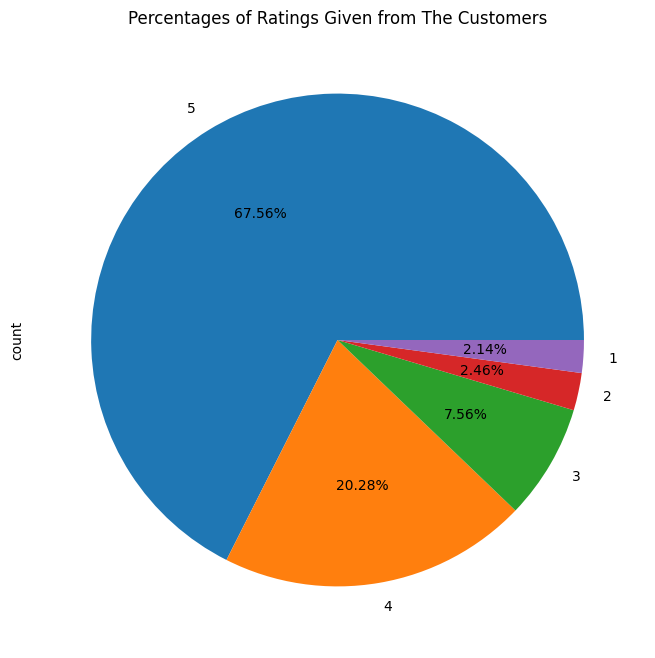

In [12]:
# Percentages of Ratings Given from The Customer
dataset.overall.value_counts().plot(kind = "pie", legend = False, autopct = "%1.2f%%", fontsize = 10, figsize=(8,8))
# Use p instead of plt as it was imported as p
p.title("Percentages of Ratings Given from The Customers", loc = "center")
p.show()

From the chart above, the majority of musical instruments sold on Amazon have perfect ratings of 5.0, meaning the condition of the products are good. If we were to denote that ratings above 3 are positive, ratings equal to 3 are neutral, and ratings under 3 are negative, we know that the number of negative reviews given in the dataset are relatively small. This might affect our model late

**Labelling Products Based On Ratings Given**

Our dataset does not have any dependent variable, or in other words we haven't had any prediction target yet. We will categorize each sentiment according to ratings given for each row based on the explanation before: Positive Label for products with rating bigger than 3.0, Neutral Label for products with rating equal to 3.0, else Negative Labe

In [13]:

def Labelling(Rows):
  if(Rows["overall"] > 3.0):
    Label = "Positive"
  elif(Rows["overall"] < 3.0):
    Label = "Negative"
  else:
    Label = "Neutral"
  return Label

In [14]:
dataset["sentiment"] = dataset.apply(Labelling, axis = 1)

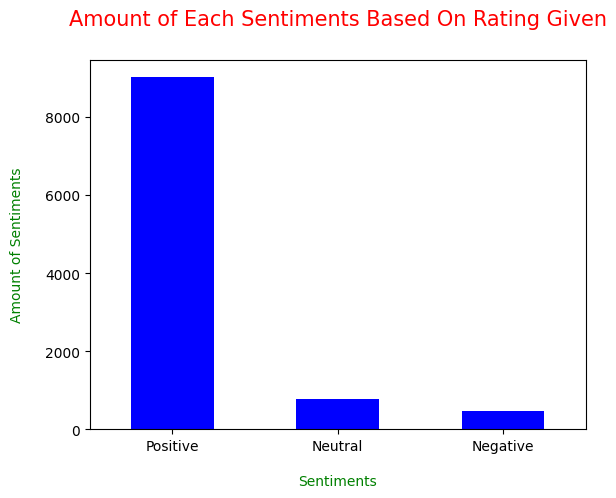

In [15]:
dataset["sentiment"].value_counts().plot(kind = "bar", color = "blue")
# Changed plt to p to match the import statement
p.title("Amount of Each Sentiments Based On Rating Given", loc = "center", fontsize = 15, color = "red", pad = 25)
p.xlabel("Sentiments", color = "green", fontsize = 10, labelpad = 15)
p.xticks(rotation = 0)
p.ylabel("Amount of Sentiments", color = "green", fontsize = 10, labelpad = 15)
p.show()

In this part we can actually change the labels into numeric values but for the sake of experiments we will do it later. Also, notice that from the graph we can know that most of our data contains positive sentiments, which is true from the exploration before

Text **Preprocessing**

Text **Cleaning**

In [16]:

def Text_Cleaning(Text):
  # Lowercase the texts
  Text = Text.lower()

  # Cleaning punctuations in the text
  punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  Text = Text.translate(punc)

  # Removing numbers in the text
  Text = re.sub(r'\d+', '', Text)

  # Remove possible links
  Text = re.sub('https?://\S+|www\.\S+', '', Text)

  # Deleting newlines
  Text = re.sub('\n', '', Text)

  return Text

Text **Processing**

In [17]:

# Stopwords
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

def Text_Processing(Text):
  Processed_Text = list()
  Lemmatizer = WordNetLemmatizer()

  # Tokens of Words
  Tokens = nltk.word_tokenize(Text)

  # Removing Stopwords and Lemmatizing Words
  # To reduce noises in our dataset, also to keep it simple and still
  # powerful, we will only omit the word `not` from the list of stopwords

  for word in Tokens:
    if word not in Stopwords:
      Processed_Text.append(Lemmatizer.lemmatize(word))

  return(" ".join(Processed_Text))

Exploratory Data **Analysis**

Overview of The **Dataset**

In [18]:
# Overview of The Dataset
dataset.head(n = 10)

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5,1393545600,"02 28, 2014","Not much to write about here, but it does exac...",Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5,1363392000,"03 16, 2013",The product does exactly as it should and is q...,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",3,1377648000,"08 28, 2013",The primary job of this device is to block the...,Neutral
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5,1392336000,"02 14, 2014",Nice windscreen protects my MXL mic and preven...,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5,1392940800,"02 21, 2014",This pop filter is great. It looks and perform...,Positive
5,A2A039TZMZHH9Y,B00004Y2UT,"Bill Lewey ""blewey""","[0, 0]",5,1356048000,"12 21, 2012",So good that I bought another one. Love the h...,Positive
6,A1UPZM995ZAH90,B00004Y2UT,Brian,"[0, 0]",5,1390089600,"01 19, 2014","I have used monster cables for years, and with...",Positive
7,AJNFQI3YR6XJ5,B00004Y2UT,"Fender Guy ""Rick""","[0, 0]",3,1353024000,"11 16, 2012",I now use this cable to run from the output of...,Neutral
8,A3M1PLEYNDEYO8,B00004Y2UT,"G. Thomas ""Tom""","[0, 0]",1,1215302400,"07 6, 2008",Perfect for my Epiphone Sheraton II. Monster ...,Negative
9,AMNTZU1YQN1TH,B00004Y2UT,Kurt Robair,"[0, 0]",5,1389139200,"01 8, 2014",Monster makes the best cables and a lifetime w...,Positive


With the overview above, we know that for sentiment analysis that we will do, reviews is important to our model and we should use this aspect as our feature. By using this feature, we will need to predict what our sentiment will be classified into

In [19]:
dataset.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10261,3
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013","Not much to write about here, but it does exac...",Positive
freq,42,163,66,6796,NaN,NaN,40,1,9013
mean,NaN,NaN,NaN,NaN,4.486502,1.360606e+09,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.897657,3.779735e+07,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN,NaN


Now, we will go back to statistic description of our dataset. Intuitively, the other features from our dataset does not really have any impact in determining our sentiment later. We might use the helpful part in our model, but as we can see from the description above, the top values of it is [0,0], which means that most users do not really take their votes in it. Because of it, we can also decide that we don't really need it in our model

**Polarity, Review Length, and Word Counts**


To justify our analysis before, we will dive further into the dataset a bit more from the polarity of the texts, also from the words used in the reviews. We will generate some new columns in our dataset and visualize it.

Polarity

In [20]:
dataset["polarity"] = dataset["reviews"].map(lambda Text: TextBlob(Text).sentiment.polarity)

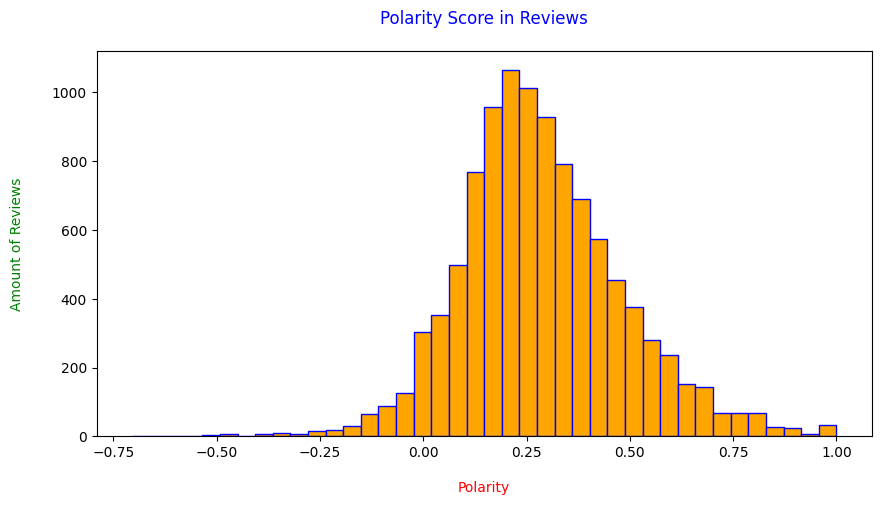

In [21]:
dataset["polarity"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
p.title("Polarity Score in Reviews", color = "blue", pad = 20)
p.xlabel("Polarity", labelpad = 15, color = "red")
p.ylabel("Amount of Reviews", labelpad = 20, color = "green")

p.show()

Reviews with negative polarity will be in range of [-1, 0), neutral ones will be 0.0, and positive reviews will have the range of (0, 1].

From the histogram above, we know that most of the reviews are distributed in positive sentiments, meaning that what we extracted from our analysis before is true. Statistically, this histogram shows that our data is normally distributed, but not with standard distribution. In conclusion, we know for sure that our analysis about the amount of sentiments from the reviews is correct and corresponds to the histogram above.

Review **Length**

In [22]:
dataset["length"] = dataset["reviews"].astype(str).apply(len)

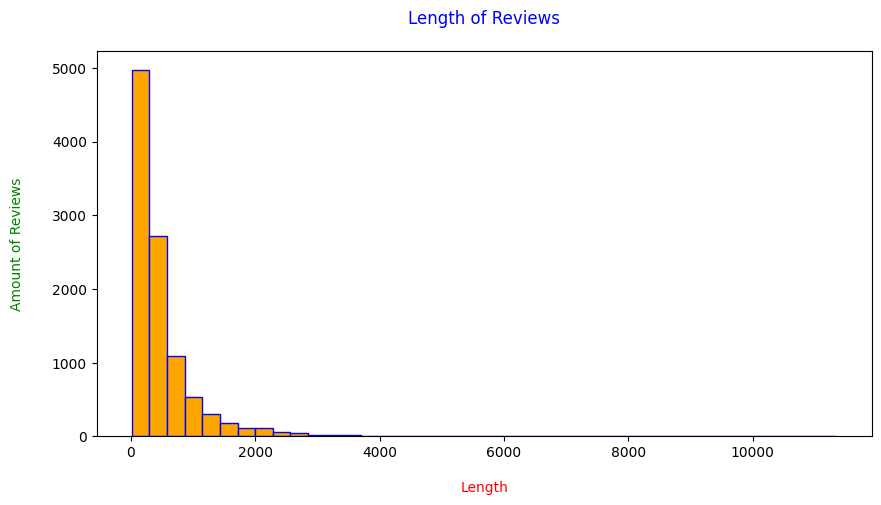

In [23]:
dataset["length"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
p.title("Length of Reviews", color = "blue", pad = 20)
p.xlabel("Length", labelpad = 15, color = "red")
p.ylabel("Amount of Reviews", labelpad = 20, color = "green")

p.show()


Based on this, we know that our review has text length between approximately 0-1000 characters. The distribution itself has positive skewness, or in other words it is skewed right, and this means that our reviews rarely has larger length than 1000 characters. Of course, the review that we use here is affected by the text preprocessing phase, so the length might not be the actual value of the review itself as some words might have been omitted already. This will also have the same effect when we count the tatal of words in our reviews.

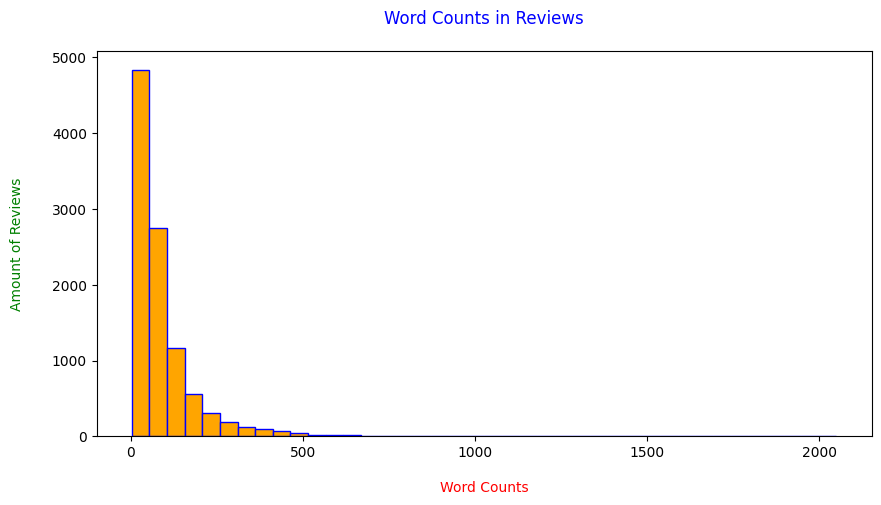

In [24]:
dataset["word_counts"] = dataset["reviews"].apply(lambda x: len(x.split())) # Create a new column 'word_counts' by counting the number of words in each review.
dataset["word_counts"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
p.title("Word Counts in Reviews", color = "blue", pad = 20)
p.xlabel("Word Counts", labelpad = 15, color = "red")
p.ylabel("Amount of Reviews", labelpad = 20, color = "green")

p.show()

N-Gram Analysis


N-Gram **Function**

In [25]:
def Gram_Analysis(Corpus, Gram, N):
  # Vectorizer
  Vectorizer = CountVectorizer(stop_words = Stopwords, ngram_range=(Gram,Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

Filter The DataFrame Based On **Sentiment**

In [26]:
# Use dropna() so the base DataFrame is not affected
Positive = dataset[dataset["sentiment"] == "Positive"].dropna()
Neutral = dataset[dataset["sentiment"] == "Neutral"].dropna()
Negative = dataset[dataset["sentiment"] == "Negative"].dropna()


Unigram of Reviews Based on Sentiments

In [27]:
def Gram_Analysis(Corpus, Gram, N):
    # Vectorizer
    # Convert Stopwords set to a list
    Stopwords_list = list(Stopwords)
    Vectorizer = CountVectorizer(stop_words=Stopwords_list, ngram_range=(Gram, Gram))

    # N-Grams Matrix
    ngrams = Vectorizer.fit_transform(Corpus)

    # N-Grams Frequency
    Count = ngrams.sum(axis=0)

    # List of Words
    words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

    # Sort Descending With Key = Count
    words = sorted(words, key=lambda x: x[1], reverse=True)

    return words[:N]

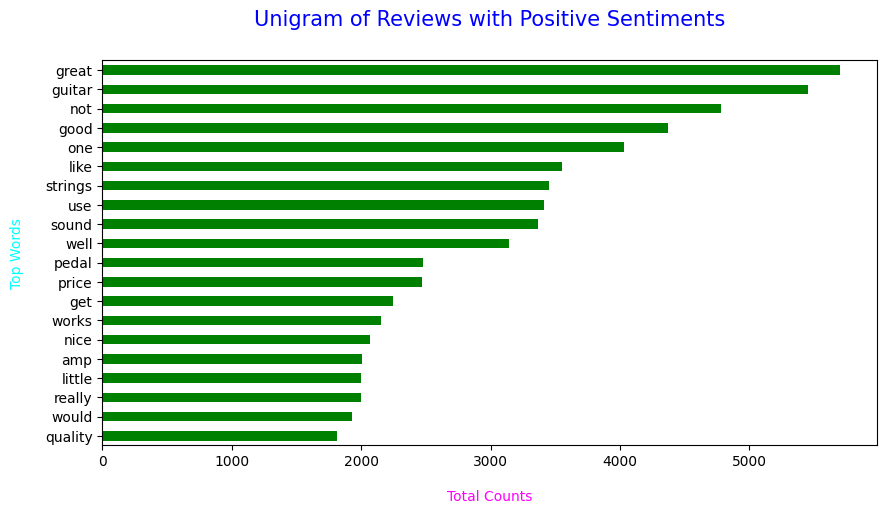

In [28]:
# Call Gram_Analysis and store the result in Unigram
Unigram = pd.DataFrame(Gram_Analysis(Positive["reviews"], 1, 20), columns=["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
p.title("Unigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
p.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
p.xticks(rotation = 0)
p.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
p.show()

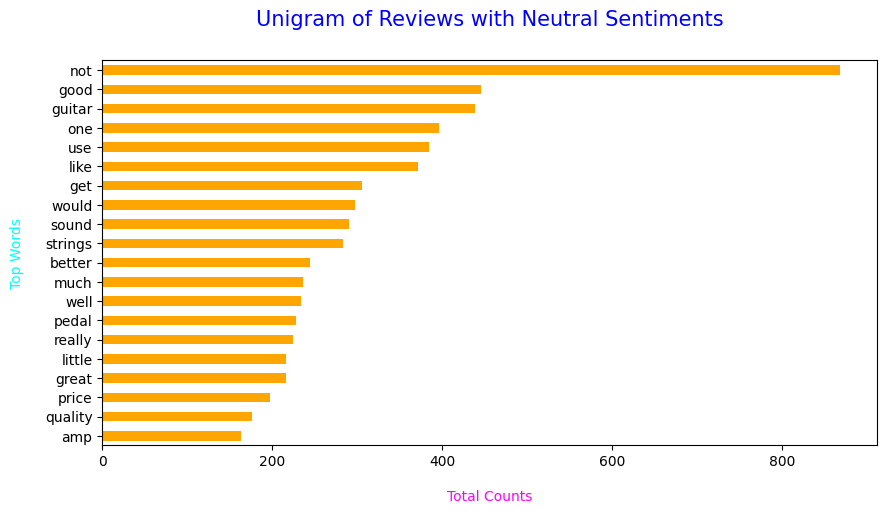

In [29]:
# Finding Unigram
words = Gram_Analysis(Neutral["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
p.title("Unigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
p.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
p.xticks(rotation = 0)
p.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
p.show()


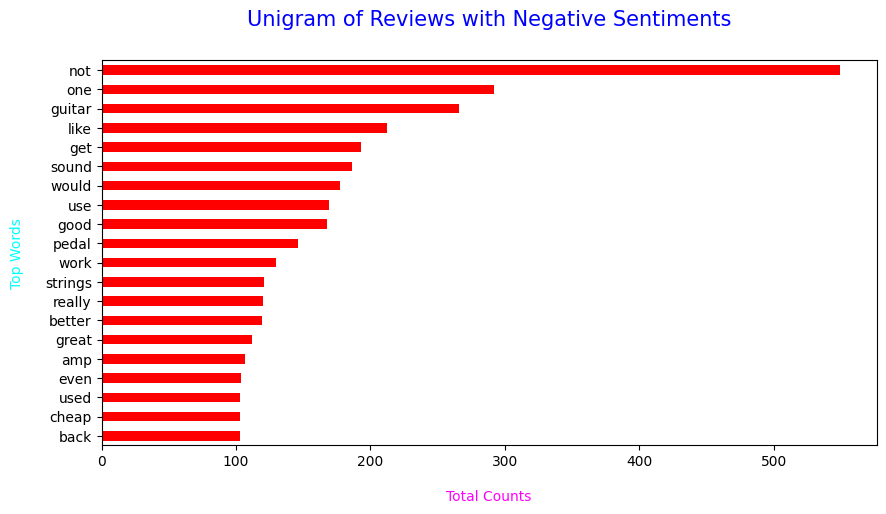

In [30]:
# Finding Unigram
words = Gram_Analysis(Negative["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
p.title("Unigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
p.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
p.xticks(rotation = 0)
p.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
p.show()

These unigrams are not really accurate, because we can clearly see that even for postive sentiments, the top unigram is the wird guitar which is an object, though from here we might know that the most frequently bought items are guitars or the complement of it. We should try to find the bigram and see how accurate it can describe each sentiment

Bigram of Reviews Based On **Sentiments**

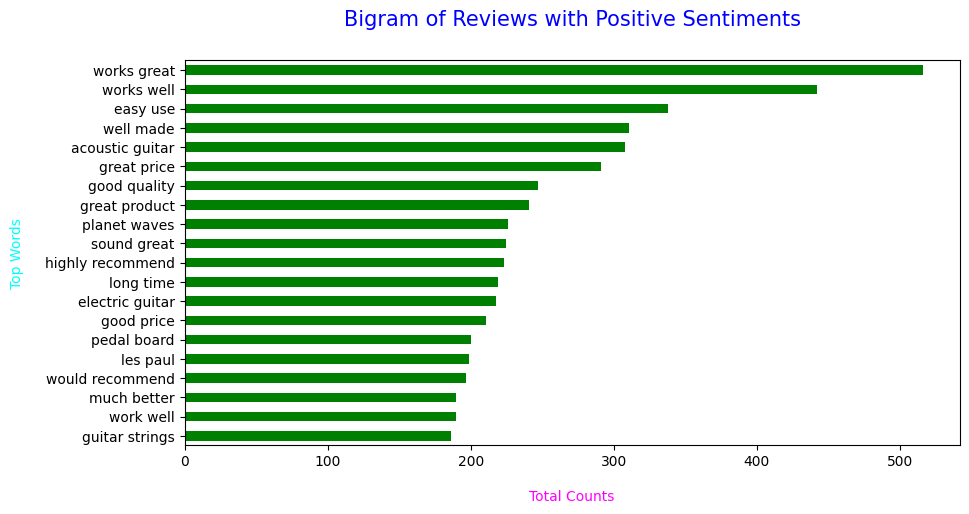

In [31]:
# Finding Bigram
words = Gram_Analysis(Positive["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
p.title("Bigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
p.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
p.xticks(rotation = 0)
p.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
p.show()

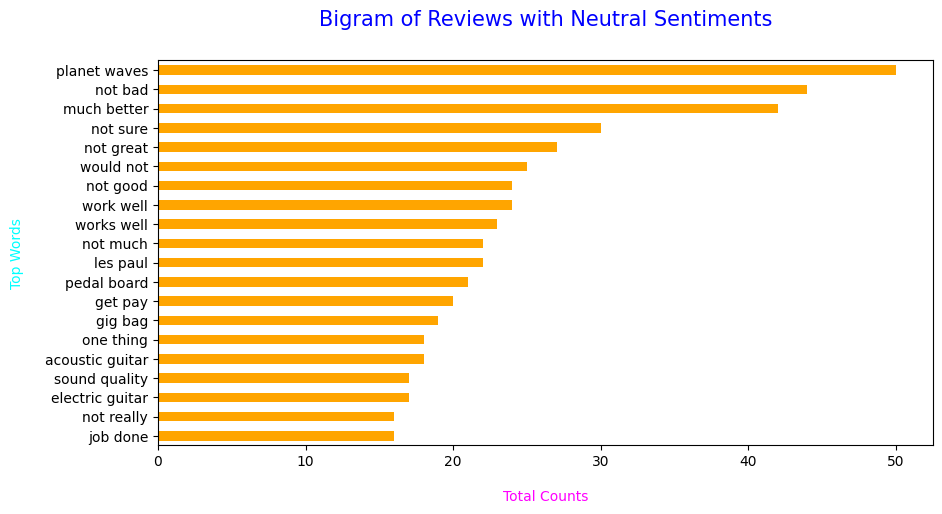

In [32]:

# Finding Bigram
words = Gram_Analysis(Neutral["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
p.title("Bigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
p.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
p.xticks(rotation = 0)
p.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
p.show()

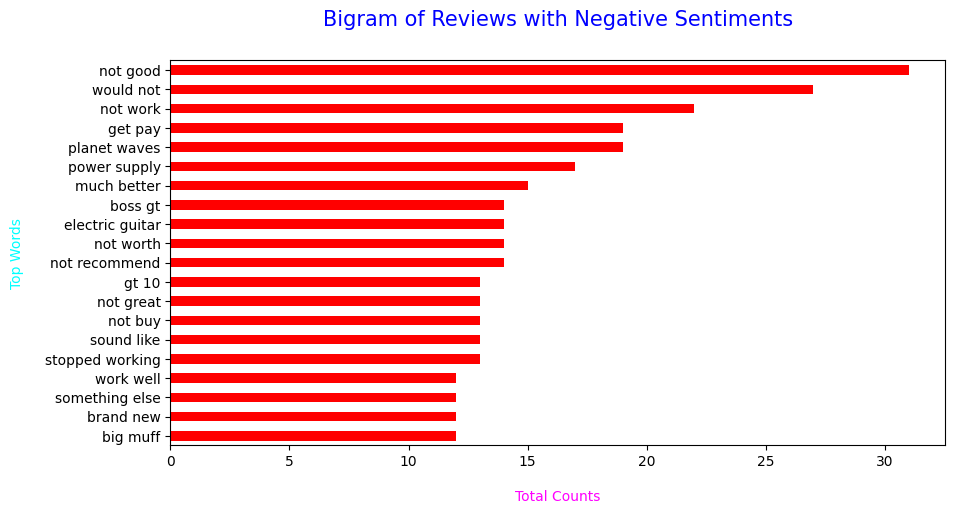

In [33]:
# Finding Bigram
words = Gram_Analysis(Negative["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
p.title("Bigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
p.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
p.xticks(rotation = 0)
p.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
p.show()

The bigrams work better than the unigrams, because we can actually see some phrases that really describe what a good sentiment is. Although, in some parts we can still see guitar objects as the top words, which make us believe that our interpretation about the most selling items are related to guitars

Trigram of Reviews Based On **Sentiment**

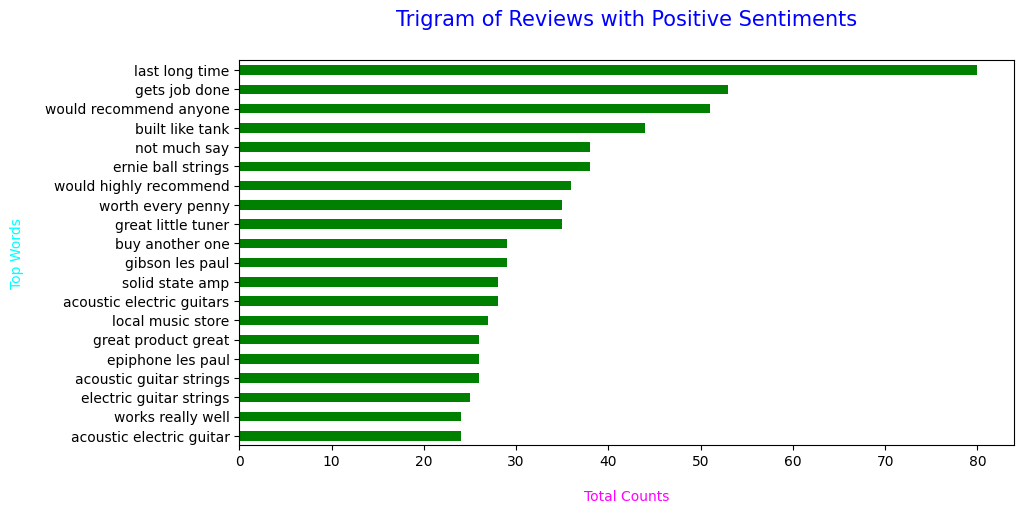

In [34]:

# Finding Trigram
words = Gram_Analysis(Positive["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
p.title("Trigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
p.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
p.xticks(rotation = 0)
p.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
p.show()


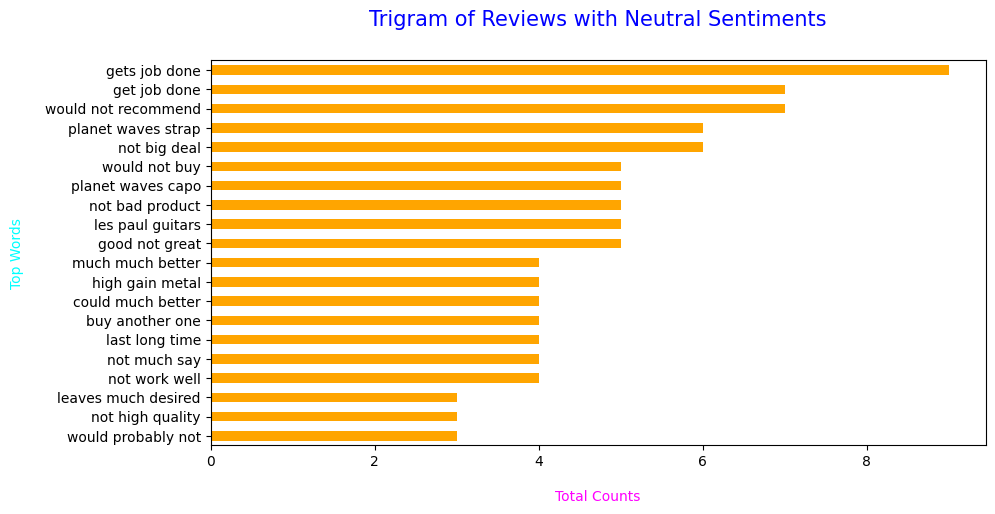

In [35]:
# Finding Trigram
words = Gram_Analysis(Neutral["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
p.title("Trigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
p.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
p.xticks(rotation = 0)
p.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
p.show()

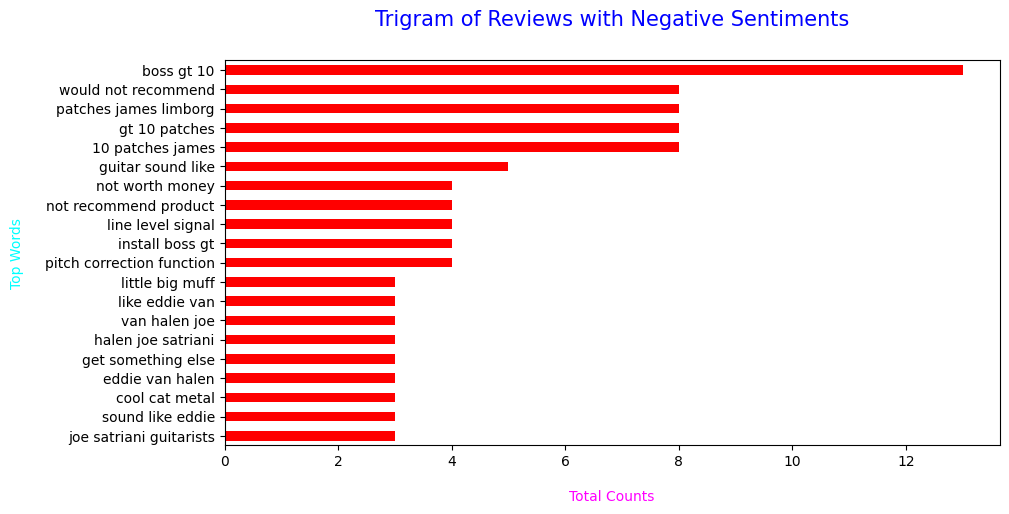

In [36]:
# Finding Trigram
words = Gram_Analysis(Negative["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
p.title("Trigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
p.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
p.xticks(rotation = 0)
p.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
p.show()


Word Clouds
Word Cloud of Reviews with Positive **Sentiment**

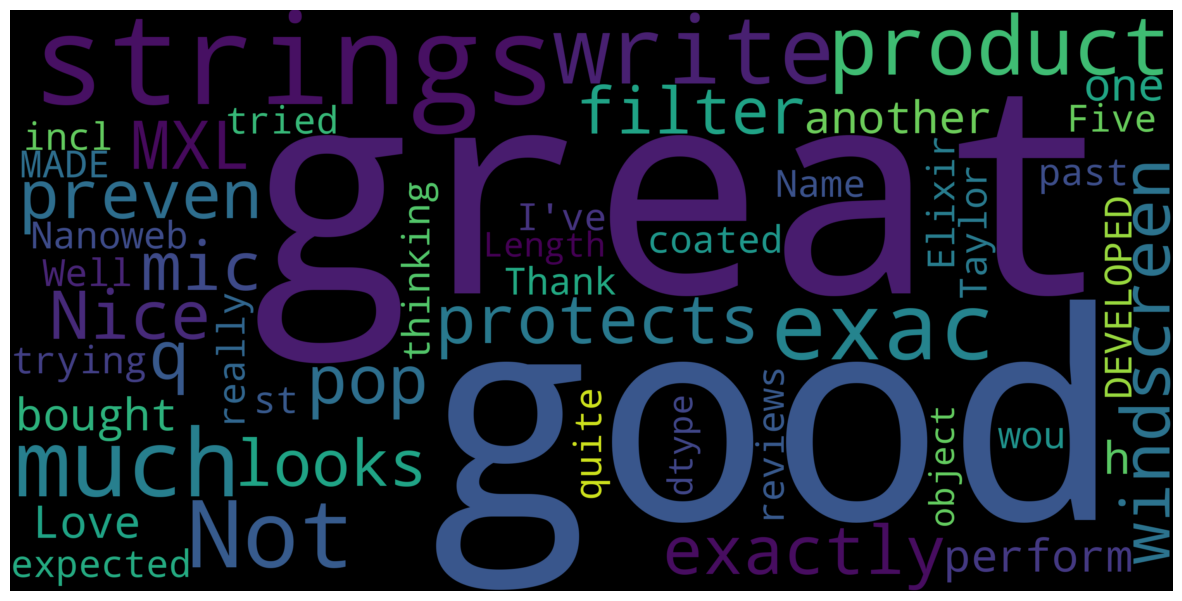

In [37]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Positive["reviews"]))
p.figure(figsize = (15, 15))
p.imshow(wordCloud, interpolation = "bilinear")
p.axis("off")
p.show()

Word Cloud of Reviews with Neutral **Sentiments**

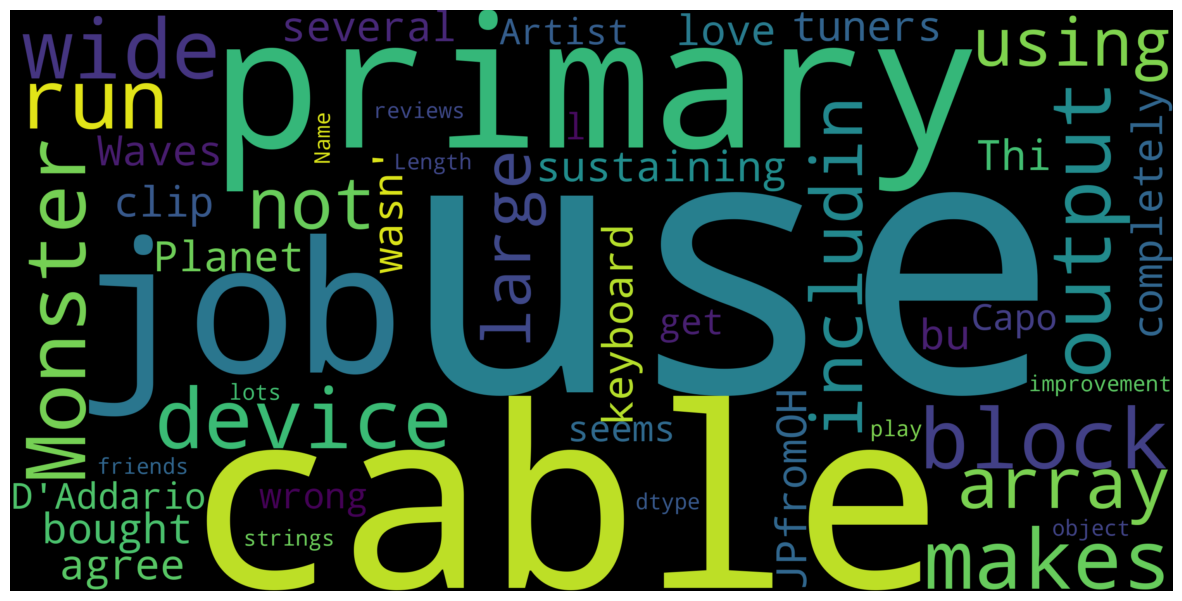

In [38]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Neutral["reviews"]))
p.figure(figsize = (15, 15))
p.imshow(wordCloud, interpolation = "bilinear")
p.axis("off")
p.show()


Word Cloud of Reviews with Negative Sentiments

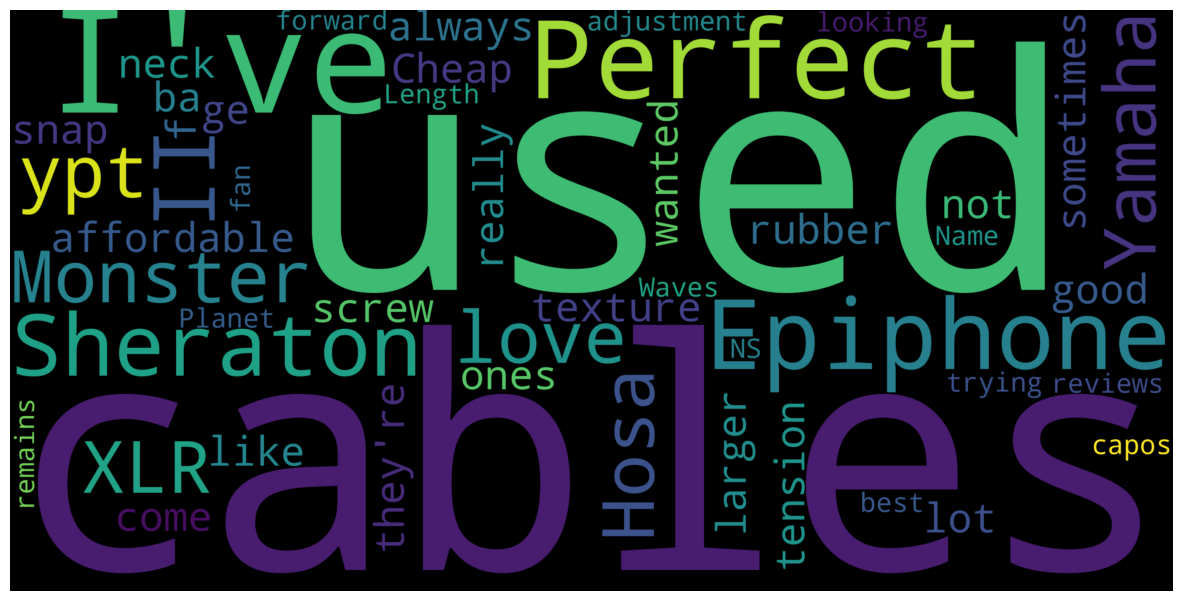

In [39]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Negative["reviews"]))
p.figure(figsize = (15, 15))
p.imshow(wordCloud, interpolation = "bilinear")
p.axis("off")
p.show()

**Feature Engineering**

Drop Insignificant Columns

In [40]:
Columns = ["reviewerID", "asin", "reviewerName", "helpful", "unixReviewTime", "reviewTime", "polarity", "length", "word_counts", "overall"]
dataset.drop(columns = Columns, axis = 1, inplace = True)


Current State of The **Dataset**

In [41]:
dataset.head()

,reviews,sentiment
0,"Not much to write about here, but it does exac...",Positive
1,The product does exactly as it should and is q...,Positive
2,The primary job of this device is to block the...,Neutral
3,Nice windscreen protects my MXL mic and preven...,Positive
4,This pop filter is great. It looks and perform...,Positive


Encoding Our Target **Variable**

In [42]:
Encoder = LabelEncoder()
dataset["sentiment"] = Encoder.fit_transform(dataset["sentiment"])

In [43]:
dataset["sentiment"].value_counts()

,count
sentiment,
2,9013
1,776
0,472


We had successfully encoded our sentiment into numbers so that our model can easily figure it out. From above, we know that the label Positive is encoded into 2, Neutral into 1, and Negative into 0. Now, we have to give importance of each words in the whole review, i.e. giving them weights. We can do this by using TF-IDF (Term Frequency - Inverse Document Frequency) Vectorizer.

In [44]:
# Defining our vectorizer with total words of 5000 and with bigram model
TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))

# Fitting and transforming our reviews into a matrix of weighed words
# This will be our independent features
X = TF_IDF.fit_transform(dataset["reviews"])

# Check our matrix shape
X.shape

(10261, 5000)

In [45]:
# Declaring our target variable
y = dataset["sentiment"]


From the shape, we successfully transformed our reviews with TF-IDF Vectorizer of 7000 top bigram words. Now, as we know from before, our data is kind of imbalanced with very little neutral and negative values compared to positive sentiments. We need to balance our dataset before going into modelling proces

Resampling Our **Dataset**

There are many ways to do resampling to an imbalanced dataset, such as SMOTE and Bootstrap Method. We will use SMOTE (Synthetic Minority Oversampling Technique) that will randomly generate new replicates of our undersampling data to balance our dataset

In [46]:
Counter(y)

Counter({2: 9013, 1: 776, 0: 472})

In [47]:
Balancer = SMOTE(random_state = 42)
X_final, y_final = Balancer.fit_resample(X, y)

In [48]:

Counter(y_final)

Counter({2: 9013, 1: 9013, 0: 9013})

Now our data is already balanced as we can see from the counter of each sentiment categories before and after the resampling with SMOTE.

Splitting Our **Dataset**

In [49]:
# Splitting Our Dataset
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, random_state = 42)

**Model Selection and Evaluation**

We do not really know what is the best model that fits our data well. Because of that, we will need to try every classification models available and find the best models using the Confusion Matrix and F1 Score as our main metrics, and the rest of the metrics as our support. First, we should do some cross validation techniques in order to find the best model.

**Model Building**

We are using K-Fold Cross Validation on our early dataset (before resampling) because the CV itself is not affected by the imbalanced dataset as it splits the dataset and takes into account every validations. If we use the CV on the balanced dataset that we got from resampling we should be able to get similar result

In [50]:
DTree = DecisionTreeClassifier()
LogReg = LogisticRegression()
SVC = SVC()
RForest = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [DTree, LogReg, SVC, RForest, Bayes, KNN]
Models_Dict = {0: "Decision Tree", 1: "Logistic Regression", 2: "SVC", 3: "Random Forest", 4: "Naive Bayes", 5: "K-Neighbors"}

for i, model in enumerate(Models):
  print("{} Test Accuracy: {}".format(Models_Dict[i], cross_val_score(model, X, y, cv = 10, scoring = "accuracy").mean()))


Decision Tree Test Accuracy: 0.8210689549796811
Logistic Regression Test Accuracy: 0.8825651844639186
SVC Test Accuracy: 0.8786669286003063
Random Forest Test Accuracy: 0.8812006620467645
Naive Bayes Test Accuracy: 0.7799406283750054
K-Neighbors Test Accuracy: 0.8783744360359951


We got six models on our sleeves and from the results of 10-Fold Cross Validation, we know that the Logistic Regression model is the best model with the highest accuracy, slightly beating the SVC. Because of this, we will use the best model in predicting our sentiment, also to tune our parameter and evaluate the end-result of how well the model works.

In [51]:
Classifier = LogisticRegression(random_state = 42, C = 6866.488450042998, penalty = 'l2')
Classifier.fit(X_train, y_train)

Prediction = Classifier.predict(X_test)

Hyperparameter **Tuning**

In [52]:
Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l1', 'l2']}
grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = Param, scoring = "accuracy", cv = 10, verbose = 0, n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_so

Best Accuracy: 97.52 %
Best Parameters: {'C': 10000.0, 'penalty': 'l2'}


We got a nice accuracy on our training set, which 97.52% and from our Grid Search, we are also able to find our optimal hyperparameters. It is time to finish our model using these parameters to get the best model of Logistic Regression.

**MetricsMetrics**


Accuracy On Test Set

In [53]:
# Accuracy On Test Set
print("Accuracy Score: ", accuracy_score(y_test, Prediction))

Accuracy Score:  0.9747041420118343


Really high accuracy that we got here, 95.21%. Still, we need to look out for the Confusion Matrix and F1 Score to find out about our model performance.

Visualizing Our Confusion **Matrix**

In [54]:
# Plotting Function for Confusion Matrix
def plot_cm(cm, classes, title, normalized = False, cmap = p.cm.Blues):

  p.imshow(cm, interpolation = "nearest", cmap = cmap)
  p.title(title, pad = 20)
  p.colorbar()
  tick_marks = np.arange(len(classes))
  p.xticks(tick_marks, classes)
  p.yticks(tick_marks, classes)

  if normalized:
    cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Unnormalized Confusion Matrix")

  threshold = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      p.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

  p.tight_layout()
  p.xlabel("Predicted Label", labelpad = 20)
  p.ylabel("Real Label", labelpad = 20)


Unnormalized Confusion Matrix


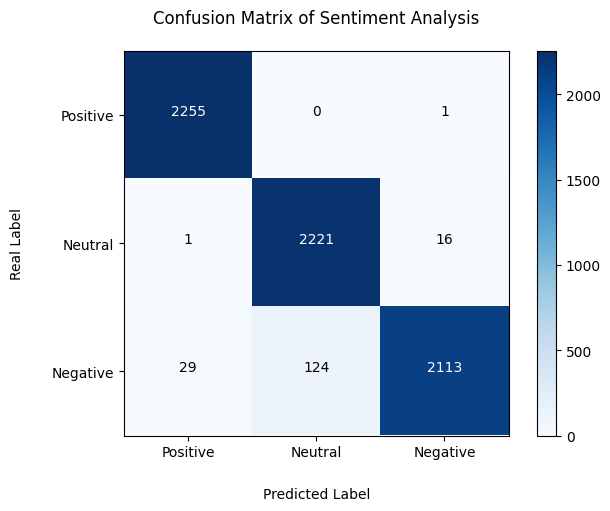

In [55]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix  # Importing the confusion_matrix function

ConfusionMatrix = confusion_matrix(y_test, Prediction)  # Computing confusion matrix

# Plotting Function for Confusion Matrix
def plot_cm(cm, classes, title, normalized=False, cmap=p.cm.Blues):
    # Code inside the function should be indented
    p.imshow(cm, interpolation="nearest", cmap=cmap)
    p.title(title, pad=20)
    p.colorbar()
    tick_marks = np.arange(len(classes))
    p.xticks(tick_marks, classes)
    p.yticks(tick_marks, classes)

    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[: np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Unnormalized Confusion Matrix")

    threshold = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            p.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > threshold else "black")

    p.tight_layout()
    p.xlabel("Predicted Label", labelpad=20)
    p.ylabel("Real Label", labelpad=20)

# Now call the plot_cm function with the calculated ConfusionMatrix
plot_cm(ConfusionMatrix, classes=["Positive", "Neutral", "Negative"],
        title="Confusion Matrix of Sentiment Analysis")

What we can gain from the Confusion Matrix above is that the model overall works well. It is able to categorize both positive and neutral sentiments correctly, while it seems to struggle a bit at determining negative sentiments. Of course, this is the effect of imbalanced data that we got from our original dataset, and luckily we can minimize the effect thanks to our SMOTE resampling before.

Classification Scores



In [56]:
print(classification_report(y_test, Prediction))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2256
           1       0.95      0.99      0.97      2238
           2       0.99      0.93      0.96      2266

    accuracy                           0.97      6760
   macro avg       0.98      0.97      0.97      6760
weighted avg       0.98      0.97      0.97      6760



Overall, to each of our sentiment categories, we got F1 Score of 95%, which is great and because of that we can conclude that our model works well on the dataset.

Conclusion

Dataset
**bold text**
Our dataset contains many features about user reviews on musical instruments. But, we rarely need those features as our model variables because those features are not really important for sentiment analysis.

We might need to omit our part of removing stopwords in our preprocessing phase, because there might be some important words in determining user sentiments in our model.

From our text analysis, we know that most of the transactions made are related to guitars or other string-based instruments. We can say that guitar got a really high attention from the customers' pool and the sellers can emphasize their products on this instruments.

**Model**

We tried almost all classification models available. By using 10-Fold Cross Validation, we get that Logistic Regression Model got the best accuracy and we decided to use this model and tune it.
On our attempt on making prediction to our test set, we also received a nice accuracy and high F1 Score. This means that our model works well on sentiment analysis.
We need to consider more Cross Validation Method, such as Stratified K-Fold so that we do not really need to do resampling on our dataset. Also, we are fine without data scaling, but it is highly suggested to do it.